# Introduction

In this competition, you must create an algorithm to identify metastatic cancer in small image patches taken from larger digital pathology scans. The data for this competition is a slightly modified version of the PatchCamelyon (PCam) benchmark dataset (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates).

In this week's assignment, I am comparing the VGG-19 model with a custom model based on VGG on the Histopathology Cancer Detection dataset.
I am also going to compare their accuracy and performance when using RMSProp vs. Adam optimiser.


In [1]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os, os.path, shutil
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


In [2]:
# Constants
SUBMISSION_FILE_NAME = 'submission.csv'
LABELS_FILE_NAME = '../input/histopathologic-cancer-detection/train_labels.csv'
TRAIN_IMAGES = '../input/histopathologic-cancer-detection/train/'
TEST_IMAGES = '../input/histopathologic-cancer-detection/test/'
ID = 'id'
LABEL = 'label'
POS_LABEL = 1
NEG_LABEL = 0

In [3]:
# Reading the training data
train_labels = pd.read_csv(LABELS_FILE_NAME)

# Input Verification & EDA


Checking out some of the training images:

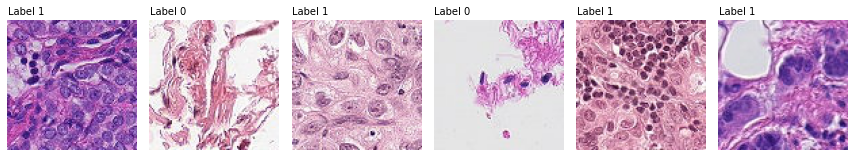

In [4]:
s = train_labels.sample(n=6).reset_index()
plt.figure(figsize=(12,12))
for i, row in s.iterrows():
    img = imread(TRAIN_IMAGES + f'{row.id}.tif')    
    label = row.label

    plt.subplot(6,6,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Label {label}', color='k')        
    plt.axis('off')

plt.tight_layout()
plt.show()

Checking the image dimensions:

In [5]:
imread(TRAIN_IMAGES + f'{train_labels.iloc[0].id}.tif').shape 

(96, 96, 3)

The images are 96px X 96px in size and have 3 channels.

Checking number of training and testing data points:

In [6]:
print(f'Shape of Training data: {train_labels.shape}')
print(f'Number of Training images: {len(os.listdir(TRAIN_IMAGES))}')
print(f'Number of Test images: {len(os.listdir(TEST_IMAGES))}')

Shape of Training data: (220025, 2)
Number of Training images: 220025
Number of Test images: 57458


There are 220,025 training images / labels and 57,458 test images.

In [7]:
train_labels.head(5)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


This is a simple CSV with `id` being the image file name and `label` indicating the presence of cancer in the image's middle 32px X 32px portion. A label value of 1 indicates that cancer is present and 0 indicates its absence.

Checking how many positive and negative samples are present:

In [8]:
counts = train_labels[LABEL].value_counts()

num_neg = counts[0]
num_pos = counts[1]

print(f'negative: {num_neg}, positive: {num_pos}')

negative: 130908, positive: 89117


Visualising the counts:

<AxesSubplot:xlabel='label', ylabel='count'>

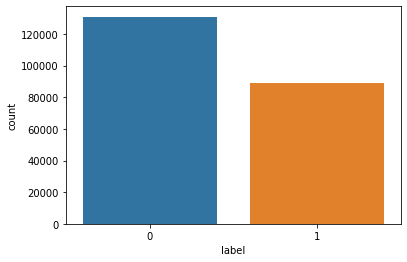

In [9]:
sns.countplot(x="label", data=train_labels)

There are 130,908 negative samples and 89,117 positive samples! There is an imbalance which will lead to bias, thus reducing the models' accuracy. We could use the F1 score, recall and AUC.



# Preprocessing

We can rebalance the dataset to remove bias during training.

In [10]:
train_pos = train_labels[train_labels[LABEL] == POS_LABEL]
train_neg = train_labels[train_labels[LABEL] == NEG_LABEL].sample(n = num_pos)

train_balanced = pd.concat([train_pos, train_neg]).sample(frac = 1, random_state = 5829).reset_index(drop = True)
train_balanced.head(5)

,id,label
0,df2cd56807791dc2cffdf2d4399313b20cd713da,1
1,3d18f2e77cd08ab8e15d60fd6f53808675d59f31,0
2,5d24ae94b99ca5da673f3964a752d517216f9f58,1
3,d30e1e6751ef330831b3216e1dc553cc861fd0aa,1
4,b05cc27e24859a2f0ed54355dfd5129a995c7449,1


In [11]:
train_balanced.shape

(178234, 2)

<AxesSubplot:xlabel='label', ylabel='count'>

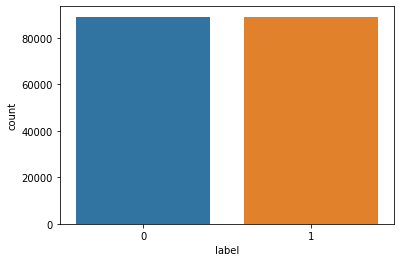

In [12]:
sns.countplot(x="label", data=train_balanced)

Also, we have to cast label as string for training the model and append '.tif' to make it easier for us to access the images.


In [13]:
train_balanced[LABEL] = train_balanced[LABEL].astype(str)
train_balanced.id = train_balanced.id + '.tif'
train_balanced.dtypes

train_balanced.head(5)

,id,label
0,df2cd56807791dc2cffdf2d4399313b20cd713da.tif,1
1,3d18f2e77cd08ab8e15d60fd6f53808675d59f31.tif,0
2,5d24ae94b99ca5da673f3964a752d517216f9f58.tif,1
3,d30e1e6751ef330831b3216e1dc553cc861fd0aa.tif,1
4,b05cc27e24859a2f0ed54355dfd5129a995c7449.tif,1


Now that the dataset is balanced we'll split the training dataset into train / validation subset.



In [14]:
df_train, df_val = train_test_split(train_balanced, test_size=0.25, random_state=5829, stratify=train_balanced.label)

imgDataGen = ImageDataGenerator(rescale=1/255)

train_gen = imgDataGen.flow_from_dataframe(
    dataframe = df_train,
    directory = TRAIN_IMAGES,
    x_col = ID,
    y_col = LABEL,
    batch_size = 64,
    seed = 5829,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

valid_gen = imgDataGen.flow_from_dataframe(
    dataframe = df_val,
    directory = TRAIN_IMAGES,
    color_mode = 'rgb',
    x_col = ID,
    y_col = LABEL,
    batch_size = 64,
    seed = 5829,
    shuffle = True,
    class_mode = 'binary',
    target_size = (96,96))

Found 133675 validated image filenames belonging to 2 classes.
Found 44559 validated image filenames belonging to 2 classes.


We also need to calculate the number of training and validation steps

In [15]:
train_steps = np.ceil(len(train_gen) / 64) # since our batch size is 64
validation_steps = np.ceil(len(valid_gen) / 64)

print(f'train_steps: {train_steps}, validation_steps: {validation_steps}')

train_steps: 33.0, validation_steps: 11.0


# Building the models
Let's move on to the models building / training.

VGG19 is a variant of VGG model which consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer).
Let's use the pre-trained VGG19 model from Keras trained on the popular imagenet dataset. It should be fully capable of handling our use-case.
Since we intend to do binary classification, we'll remove the SoftMax layer and instead use a Sigmoid layer for the output.
Let's also use batch normalization.

In [16]:
model_vgg_base = tf.keras.applications.VGG19(input_shape = (96, 96, 3), include_top = False, weights = 'imagenet')

for layer in model_vgg_base.layers:
    layer.trainable = False
    
output_layer = keras.layers.Flatten()(model_vgg_base.output)
output_layer = keras.layers.Dense(512, activation='relu')(output_layer)
output_layer = keras.layers.BatchNormalization()(output_layer)
output_layer = keras.layers.Dropout(0.25)(output_layer)
output_layer = keras.layers.Dense(1, activation='sigmoid')(output_layer)

model_vgg = tf.keras.models.Model(model_vgg_base.input, output_layer)

model_vgg.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])

model_vgg.summary()

2022-06-21 09:01:32.989295: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 09:01:33.090214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 09:01:33.091169: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-21 09:01:33.092694: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

80150528/80134624 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
______________________________________________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
history_vgg = model_vgg.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30,
    verbose = 1
)

2022-06-21 09:01:37.049144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-06-21 09:01:39.453561: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


33/33 [==============================] - 27s 556ms/step - loss: 0.7512 - accuracy: 0.7358 - auc: 0.8044 - val_loss: 0.6713 - val_accuracy: 0.7031 - val_auc: 0.8527
Epoch 2/30
33/33 [==============================] - 17s 532ms/step - loss: 0.4643 - accuracy: 0.7983 - auc: 0.8748 - val_loss: 0.5718 - val_accuracy: 0.7727 - val_auc: 0.8460
Epoch 3/30
33/33 [==============================] - 17s 522ms/step - loss: 0.4632 - accuracy: 0.7926 - auc: 0.8742 - val_loss: 0.4640 - val_accuracy: 0.8082 - val_auc: 0.8915
Epoch 4/30
33/33 [==============================] - 17s 517ms/step - loss: 0.4593 - accuracy: 0.7955 - auc: 0.8747 - val_loss: 0.4492 - val_accuracy: 0.8182 - val_auc: 0.8954
Epoch 5/30
33/33 [==============================] - 17s 518ms/step - loss: 0.4306 - accuracy: 0.8007 - auc: 0.8866 - val_loss: 0.7326 - val_accuracy: 0.6932 - val_auc: 0.8718
Epoch 6/30
33/33 [==============================] - 16s 499ms/step - loss: 0.4153 - accuracy: 0.8101 - auc: 0.8947 - val_loss: 0.4448 - 

In [37]:
history = {}
for k in history_vgg.history.keys():
    history[k] = sum([history_vgg.history[k]], [])

epoch_range = range(1, len(history['loss']) +1)
s = slice(0, None)
n = int(len(history.keys()) / 2)

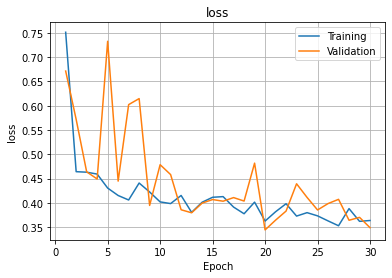

In [38]:
k = list(history.keys())[0]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

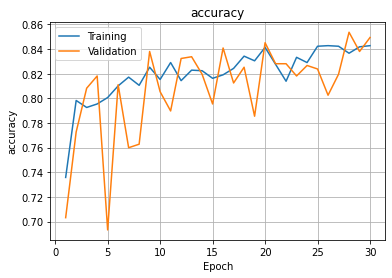

In [39]:
k = list(history.keys())[1]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

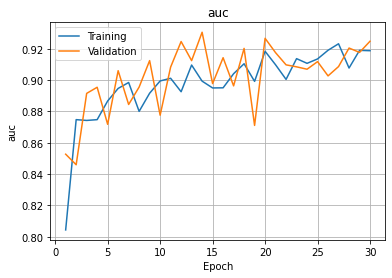

In [40]:
k = list(history.keys())[2]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

In [19]:
# Custom Model based on VGG architecture

# Consists of 3 sets of 3 convolution layers
custom_model = Sequential()
custom_model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(32, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(BatchNormalization())

custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(64, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(BatchNormalization())

custom_model.add(Conv2D(128, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(Conv2D(128, (3, 3)))
custom_model.add(Activation('relu'))
custom_model.add(MaxPooling2D(pool_size=(2, 2)))
custom_model.add(BatchNormalization())
          
custom_model.add(Flatten())
custom_model.add(Dropout(0.2))
custom_model.add(Dense(512))
custom_model.add(Activation('relu'))

custom_model.add(Dropout(0.2))
custom_model.add(Dense(256))
custom_model.add(Activation('relu'))

custom_model.add(Dropout(0.2))
custom_model.add(Dense(64))
custom_model.add(Activation('relu')) 

custom_model.add(Dropout(0.2))
custom_model.add(Dense(1, activation='sigmoid'))
custom_model.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])

custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 94, 94, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 32)        0

In [20]:
history_custom = custom_model.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30,
    verbose = 1
)

Epoch 1/30
33/33 [==============================] - 15s 380ms/step - loss: 0.5830 - accuracy: 0.7292 - auc_1: 0.7916 - val_loss: 0.7170 - val_accuracy: 0.5000 - val_auc_1: 0.5487
Epoch 2/30
33/33 [==============================] - 13s 394ms/step - loss: 0.5308 - accuracy: 0.7557 - auc_1: 0.8282 - val_loss: 0.7415 - val_accuracy: 0.5114 - val_auc_1: 0.5581
Epoch 3/30
33/33 [==============================] - 13s 383ms/step - loss: 0.5108 - accuracy: 0.7685 - auc_1: 0.8383 - val_loss: 0.8392 - val_accuracy: 0.4844 - val_auc_1: 0.5228
Epoch 4/30
33/33 [==============================] - 12s 373ms/step - loss: 0.5012 - accuracy: 0.7732 - auc_1: 0.8419 - val_loss: 0.9149 - val_accuracy: 0.4972 - val_auc_1: 0.5697
Epoch 5/30
33/33 [==============================] - 12s 358ms/step - loss: 0.4852 - accuracy: 0.7708 - auc_1: 0.8543 - val_loss: 1.0374 - val_accuracy: 0.5213 - val_auc_1: 0.6257
Epoch 6/30
33/33 [==============================] - 12s 362ms/step - loss: 0.5064 - accuracy: 0.7647 - au

In [41]:
history = {}
for k in history_custom.history.keys():
    history[k] = sum([history_custom.history[k]], [])

epoch_range = range(1, len(history['loss']) +1)
s = slice(0, None)
n = int(len(history.keys()) / 2)

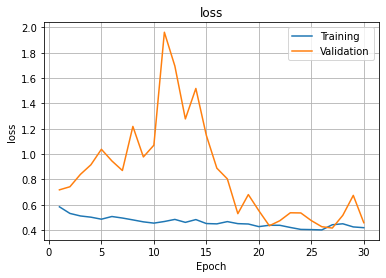

In [42]:
k = list(history.keys())[0]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

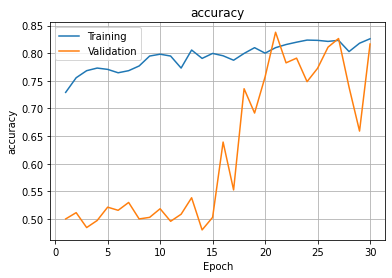

In [43]:
k = list(history.keys())[1]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

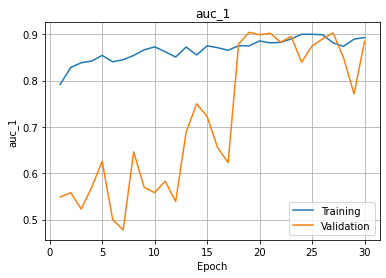

In [44]:
k = list(history.keys())[2]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

After comparing the metrics, we can conclude that VGG19 performs better than the custom model on this dataset even though it takes longer to train. 

Next, we'll try using the Adam optimizer instead of RMSProp for the VGG19 model and see if the performance improves.

In [22]:
model_vgg.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'binary_crossentropy',metrics = ['accuracy', keras.metrics.AUC()])
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 96, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 96, 96, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 48, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 48, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 48, 48, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 24, 24, 128)       0     

In [23]:
history_vgg_adam = model_vgg.fit(
    x = train_gen,
    steps_per_epoch = train_steps,
    validation_data = valid_gen,
    validation_steps = validation_steps,
    epochs = 30,
    verbose = 1
)

Epoch 1/30
33/33 [==============================] - 12s 330ms/step - loss: 0.3882 - accuracy: 0.8248 - auc_2: 0.9067 - val_loss: 0.4044 - val_accuracy: 0.8139 - val_auc_2: 0.9022
Epoch 2/30
33/33 [==============================] - 11s 333ms/step - loss: 0.3681 - accuracy: 0.8343 - auc_2: 0.9165 - val_loss: 0.3938 - val_accuracy: 0.8267 - val_auc_2: 0.9101
Epoch 3/30
33/33 [==============================] - 11s 323ms/step - loss: 0.3579 - accuracy: 0.8452 - auc_2: 0.9211 - val_loss: 0.4118 - val_accuracy: 0.8182 - val_auc_2: 0.9273
Epoch 4/30
33/33 [==============================] - 10s 311ms/step - loss: 0.3982 - accuracy: 0.8101 - auc_2: 0.9007 - val_loss: 0.3628 - val_accuracy: 0.8480 - val_auc_2: 0.9205
Epoch 5/30
33/33 [==============================] - 10s 306ms/step - loss: 0.3848 - accuracy: 0.8333 - auc_2: 0.9068 - val_loss: 0.4064 - val_accuracy: 0.8196 - val_auc_2: 0.8990
Epoch 6/30
33/33 [==============================] - 10s 314ms/step - loss: 0.3757 - accuracy: 0.8419 - au

In [45]:
history = {}
for k in history_vgg_adam.history.keys():
    history[k] = sum([history_vgg_adam.history[k]], [])

epoch_range = range(1, len(history['loss']) +1)
s = slice(0, None)
n = int(len(history.keys()) / 2)

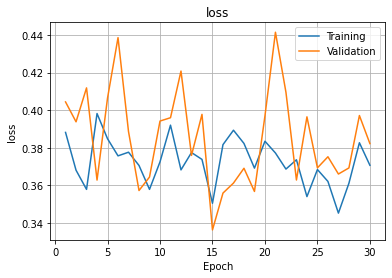

In [46]:
k = list(history.keys())[0]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

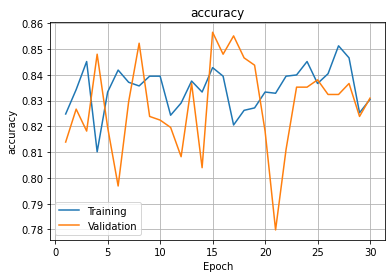

In [47]:
k = list(history.keys())[1]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

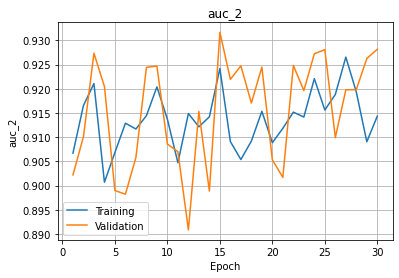

In [48]:
k = list(history.keys())[2]
plt.plot(epoch_range, history[k][s], label='Training')
plt.plot(epoch_range, history['val_' + k][s], label='Validation')
plt.xlabel('Epoch'); plt.ylabel(k); plt.title(k)
plt.grid()
plt.legend()
plt.show()

Based on the metric plots of VGG19 with RMSProp optimizer vs VGG19 with Adam optimizer, we can conclude that the model converges faster using Adam optimizer.

In [25]:
df_test = pd.DataFrame(os.listdir(TEST_IMAGES))
df_test.columns = [ID]
df_test.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [26]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe = df_test,
    directory = TEST_IMAGES,
    x_col = "id",
    batch_size = 64,
    seed = 5829,
    shuffle = False,
    class_mode = None,
    target_size = (96,96)
)

Found 57458 validated image filenames.


In [27]:
predictions_test = model_vgg.predict(test_gen, steps = test_gen.n / 2, verbose = 1)

28729/28729 [==============================] - 307s 11ms/step


In [28]:
predictions = []

for pred in predictions_test:
    if pred >= 0.5:
        predictions.append(1)
    else:
        predictions.append(0)

In [29]:
predictions[:15]

[1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1]

In [30]:
submission = df_test.copy()
submission[ID] = submission[ID].str[:-4]
submission[LABEL] = predictions
submission.head()


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


In [31]:
submission.to_csv(SUBMISSION_FILE_NAME, index = False)

# Conclusion

This was a pretty good project for my first try. I would like to try further optimizations and preprocessing operations such as image augmentation, etc. as well. These are also known to improve performance & accuracy of CNN models.